In [20]:
import pandas as pd
import seaborn as sns
import scipy.stats as sp_stats
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt

sns.set(style='white', context='notebook', rc={'figure.figsize':(12,10)}, font='sans-serif')

In [21]:
#Input and table cleaning
blasts = pd.read_csv(r"C:\Users\Roman\Documents\CleanData\NormByWell\blastsProfiles.csv")
blasts = blasts.dropna(axis=1)
blasts.set_index(['Compound','Concentration','PlateName','Count'],inplace=True)
blastTreat = blasts.groupby(by=['Compound','Concentration']).mean()
blastTreat.drop(columns=['Row','Column','Unnamed: 0'],inplace = True)
blastTreat['Celltype'] = "B"

tubes = pd.read_csv(r"C:\Users\Roman\Documents\CleanData\NormByWell\tubesProfiles.csv")
tubes = tubes.dropna(axis=1)
tubes.set_index(['Compound','Concentration','PlateName','Count'],inplace=True)
tubesTreat = tubes.groupby(by=['Compound','Concentration']).mean()
tubesTreat.drop(columns=['Row','Column','Unnamed: 0'],inplace = True)
tubesTreat['Celltype'] ='T'

treat = pd.concat([blastTreat,tubesTreat])
treat.set_index(['Celltype'], append=True, inplace=True)
treat = treat.dropna(axis=1)


In [22]:
### DROP CORRELATED columns
cor_matrix = treat.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
treatFilt = treat.drop(columns=to_drop, axis=1)

In [23]:
aggProfNP = treatFilt.to_numpy()
pca = PCA(n_components=0.9, svd_solver='full')
embed = pca.fit_transform(aggProfNP)

covMat = np.cov(embed, rowvar=False)
covMatInv = np.linalg.inv(covMat)
sampleSize=len(treatFilt.index)

In [24]:
### compute indices for each drug tick on the heatmap
heatmapInfo = pd.DataFrame(treat[0:241].reset_index().value_counts(['Compound'],sort=False),columns=['Values'])
heatmapInfo['Sum'] = heatmapInfo.cumsum()
heatmapInfo['Indices'] = heatmapInfo['Sum'] - heatmapInfo['Values']//2 
heatmapInfo.reset_index(inplace=True)

sampleInfo = treatFilt[0:241].reset_index()
sampleInfo = sampleInfo.drop(columns=['Celltype'])
sampleInfo.set_index(['Compound','Concentration'], inplace = True)

In [26]:
sample = []
mahaMat = np.empty(shape=[sampleSize,sampleSize])
for x in range(0,sampleSize):
    for y in range(0,sampleSize):
        sample.insert(y,sp.spatial.distance.mahalanobis(embed[x],embed[y],covMatInv)) # mahalanobis distance
    mahaMat[x] = sample
    sample = []

In [27]:
sample = []
pearsonMat = np.empty(shape=[sampleSize,sampleSize])
for x in range(0,sampleSize):
    for y in range(0,sampleSize):
        sample.insert(y,sp.stats.pearsonr(embed[x],embed[y])[0])    # pearson correlation
    pearsonMat[x] = sample
    sample = []

<AxesSubplot: xlabel='Myoblasts', ylabel='Myotubes'>

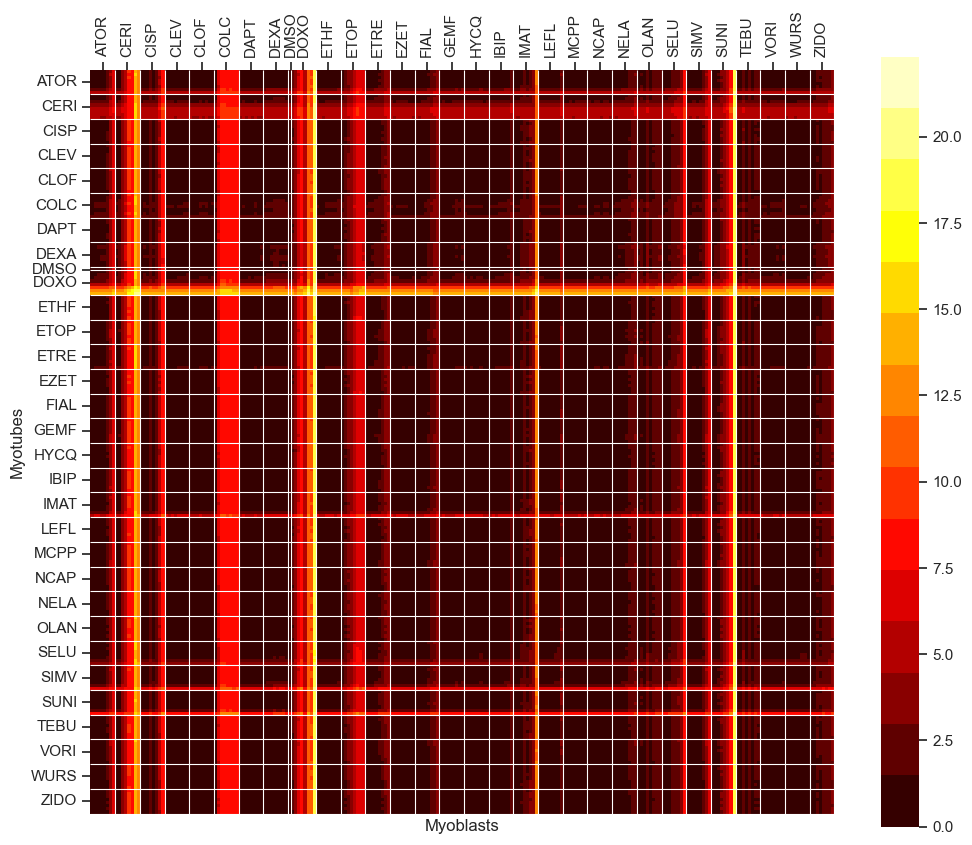

<Figure size 8400x7000 with 0 Axes>

In [28]:

palette = sns.color_palette("hot",n_colors=15)

fig = sns.heatmap(mahaDF,cmap=palette,square=True)

fig.set_xticks(heatmapInfo['Indices'])
fig.set_xticklabels(heatmapInfo.Compound.to_list())
fig.set_yticks(heatmapInfo['Indices'])
fig.set_yticklabels(heatmapInfo.Compound.to_list())
fig.hlines(heatmapInfo['Sum'], *fig.get_xlim(),color = 'white',lw=0.8)
fig.vlines(heatmapInfo['Sum'], *fig.get_xlim(),color = 'white',lw=0.8)
fig.set(xlabel= 'Myoblasts', ylabel='Myotubes')

plt.tick_params(axis='x', labelbottom = False, bottom=False, top = True, labeltop=True, labelrotation = 90)
plt.tick_params(axis='y', labelbottom = False, bottom=False, left = True, labeltop=True, labelrotation = 0)
plt.figure(dpi=700)
fig

<AxesSubplot: xlabel='Myoblasts', ylabel='Myotubes'>

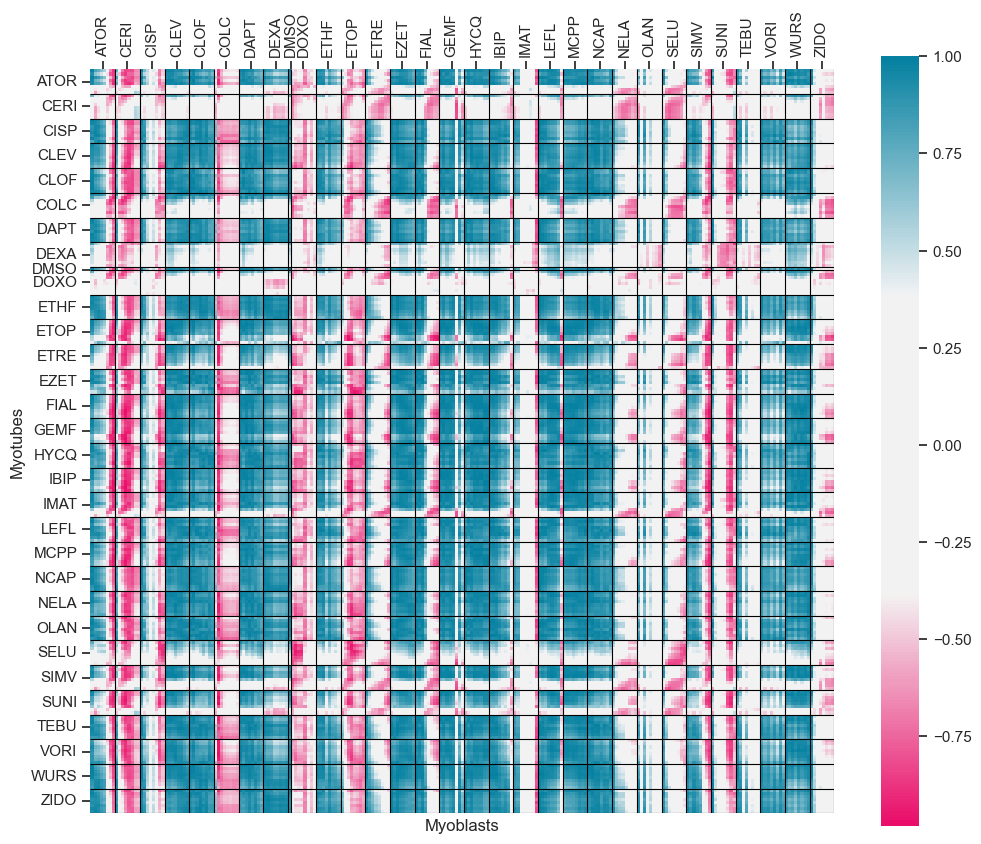

<Figure size 8400x7000 with 0 Axes>

In [29]:
palette = sns.diverging_palette(0, 225, s=99,sep=100, l=50, as_cmap=True)

fig = sns.heatmap(pearsonDF,cmap=palette,center =0.0,square=True)

fig.set_xticks(heatmapInfo['Indices'])
fig.set_xticklabels(heatmapInfo.Compound.to_list())
fig.set_yticks(heatmapInfo['Indices'])
fig.set_yticklabels(heatmapInfo.Compound.to_list())
fig.hlines(heatmapInfo['Sum'], *fig.get_xlim(),color = 'black',lw=0.8)
fig.vlines(heatmapInfo['Sum'], *fig.get_xlim(),color = 'black',lw=0.8)
fig.set(xlabel= 'Myoblasts', ylabel='Myotubes')

plt.tick_params(axis='x', labelbottom = False, bottom=False, top = True, labeltop=True, labelrotation = 90)
plt.tick_params(axis='y', labelbottom = False, bottom=False, left = True, labeltop=True, labelrotation = 0)
plt.figure(dpi=700)
fig

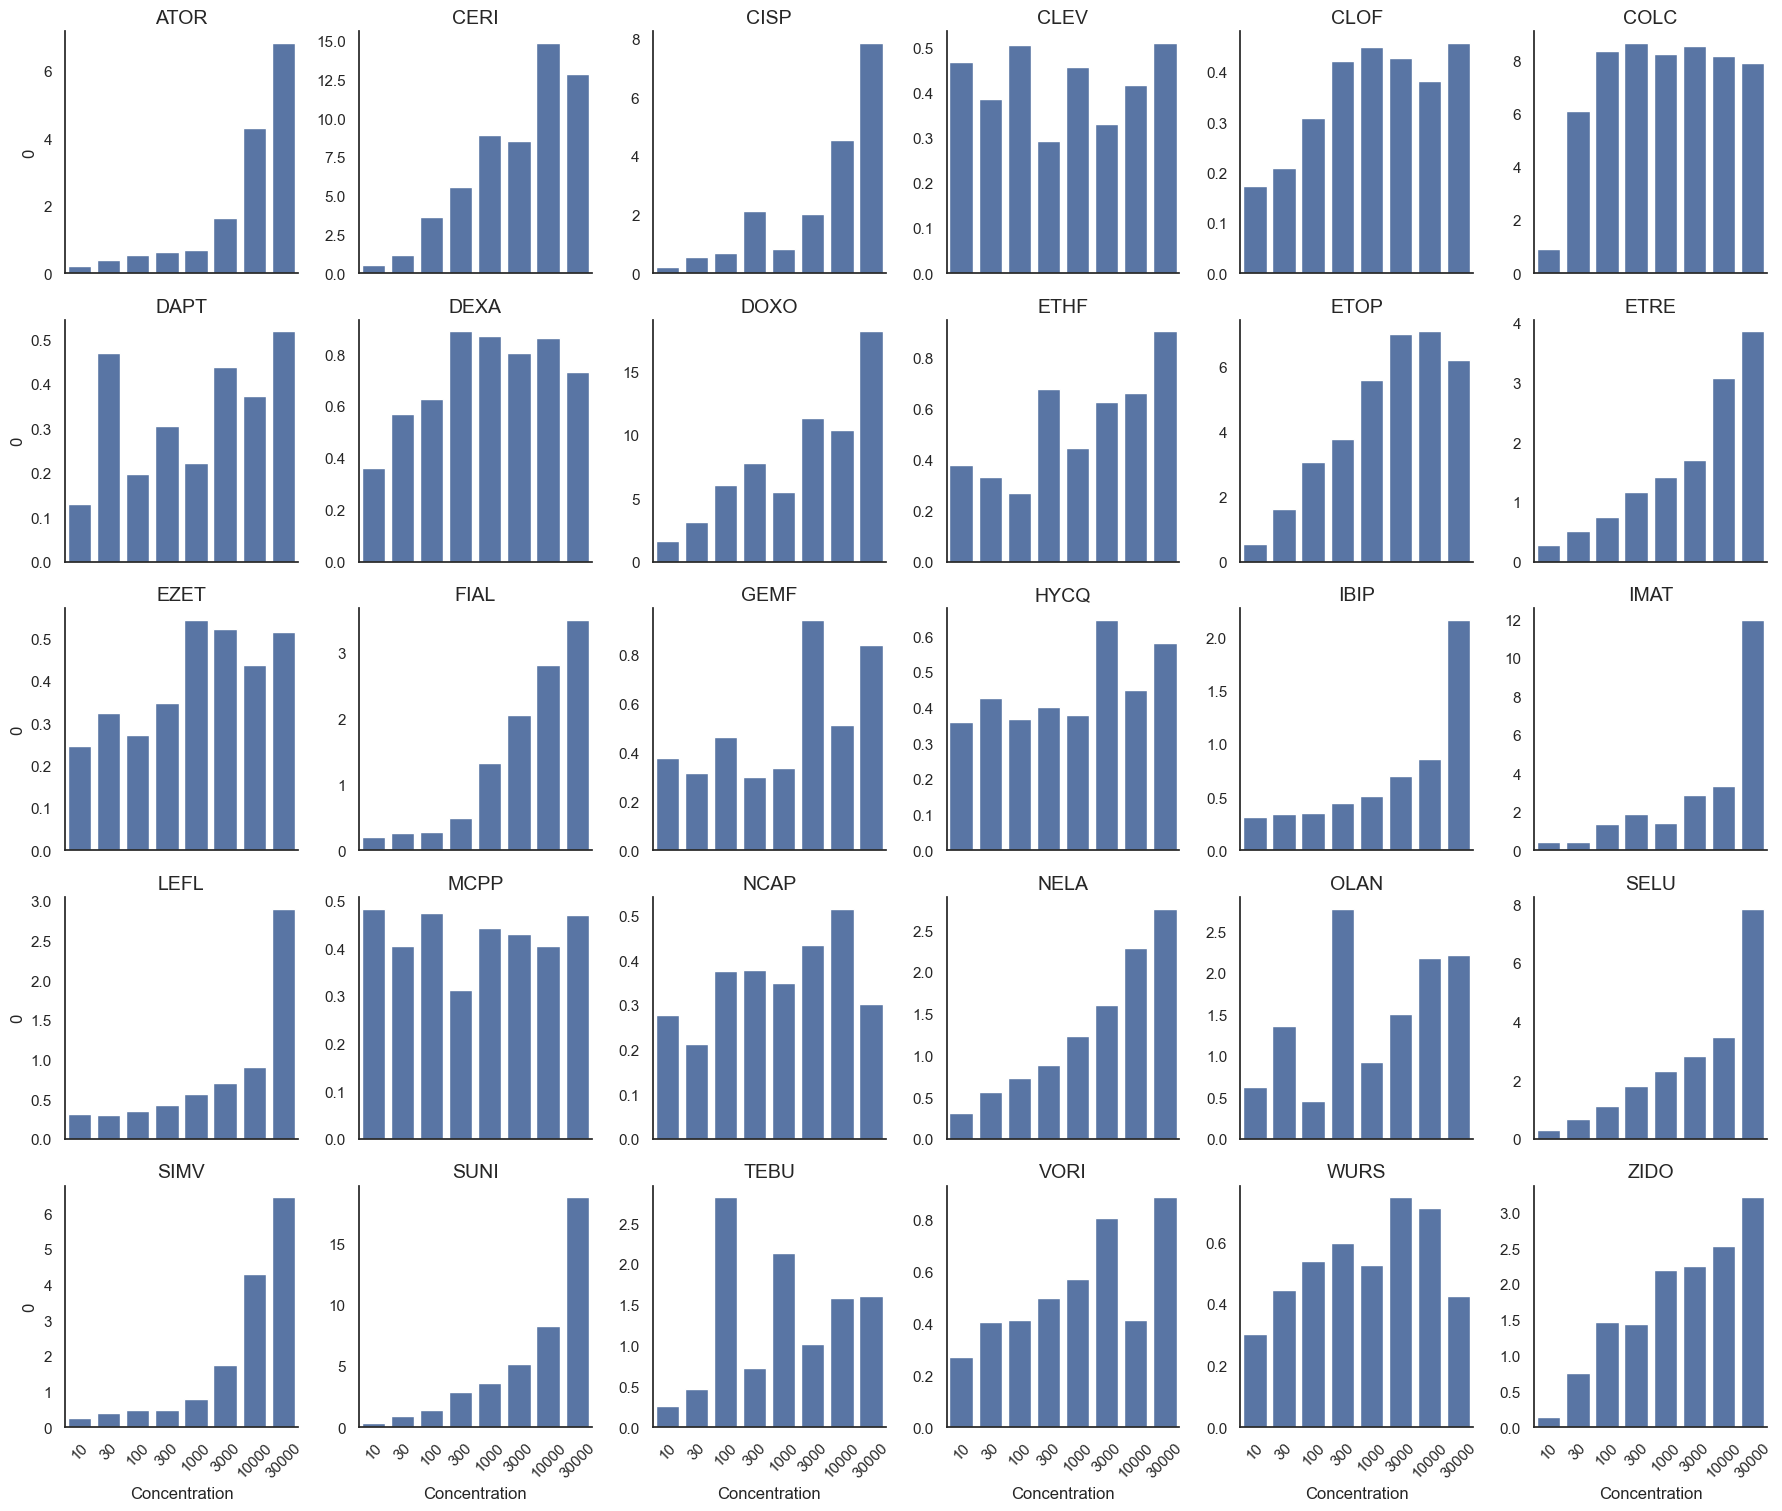

In [30]:
distToDMSO = mahaDF.loc['DMSO'].T
distToDMSO.reset_index(inplace=True)
distToDMSO['Concentration'] = distToDMSO['Concentration'].replace({0:1}) #avoid log scale issue with c=0
distToDMSO = distToDMSO[distToDMSO.Compound != 'DMSO']
distToDMSO.columns.to_flat_index()

g = sns.FacetGrid(distToDMSO, col='Compound',col_wrap=6,sharey=False,sharex=True)
g.map_dataframe(sns.barplot, x="Concentration",y=0)
g.tick_params(axis='x', labelrotation = 45)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}',size=14)